In [1]:
# Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import zeta
import seaborn as sb
import matplotlib.cm as cm
from scipy.stats import binom
import copy
from Bio import Phylo
from ete3 import Tree, TreeStyle, NodeStyle
from scipy.interpolate import interp1d

from data_analysis_utils import *

In [ ]:
# File paths
tonsil_vdjs_path = 'Data/tonsil_vdjs.tsv'
metadata_path = "Data/tonsil_LR_spatialbc_metadata.csv"
UMI_collapsed_path = "Data/UMI_collapsed_on_tissue_read_list.csv"
clone_list_path = "Data/tonsil_all_ontissue_clone_list.csv"

# Read in data
df_IGH_IF, df_IGH_EF_PBdom, df_combined, df_TRB, metadata_df, df_IGH_EF, df_IGH = data_readin(tonsil_vdjs_path, metadata_path, UMI_collapsed_path, clone_list_path)

# Write sequences of multi-clone lineages to FASTA files for tree construction
# Note that FastTree must be run separately on these files to generate the trees
lineage_ids, lineage_lens, N_trees, N_lineages_tot = prepare_sequences_for_trees(df_IGH, df_IGH_IF,df_combined, write_files = False)

c:\Users\johnd\OneDrive\Desktop\Stanford\Good Lab\Germinal_Centers\GC_Code\data_analysis_utils.py:708: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clones = pd.read_csv(clone_list_path)


Number inconsistent V calls: 482
Added 151 new lineages after pruning inconsistent V gene calls.
Number inconsistent V calls: 381
Removing 7 reads with indels in V gene mutation calls.
Updated 944 mutation calls to ensure single consensus germline per lineage.


In [3]:
# FIGURE 1

# Follicle and lineage statistics

foll_stats = df_IGH_IF.groupby('follicle').agg(
    n_UMIs = ('follicle','size'),
    n_clones = ('vdj_sequence', 'nunique'),
    n_lineages = ('lineage_id', 'nunique')
).reset_index()
foll_stats = foll_stats.sort_values(by='n_UMIs', ascending=False)

EF_stats = np.array([len(df_IGH_EF), df_IGH_EF['vdj_sequence'].nunique(), df_IGH_EF['lineage_id'].nunique()])

lineage_stats = df_IGH_IF.groupby('lineage_id').agg(
    n_UMIs=('lineage_id', 'size'),
    n_follicles=('follicle', 'nunique'),
    n_vdjs = ('vdj_sequence', 'nunique')
).reset_index()

ef_counts = df_IGH_EF['lineage_id'].value_counts().rename('EF_UMIs').reset_index()
ef_counts.columns = ['lineage_id', 'EF_UMIs']

ef_vdjs = df_IGH_EF.groupby('lineage_id')['vdj_sequence'].nunique().reset_index().rename(columns={'vdj_sequence': 'EF_VDJs'})
ef_counts = ef_counts.merge(ef_vdjs, on='lineage_id', how='left').fillna(0)
ef_counts['EF_VDJs'] = ef_counts['EF_VDJs'].astype(int)

lineage_stats = lineage_stats.merge(ef_counts, on='lineage_id', how='left').fillna(0)
lineage_stats['EF_UMIs'] = lineage_stats['EF_UMIs'].astype(int)
lineage_stats['EF_VDJs'] = lineage_stats['EF_VDJs'].astype(int)

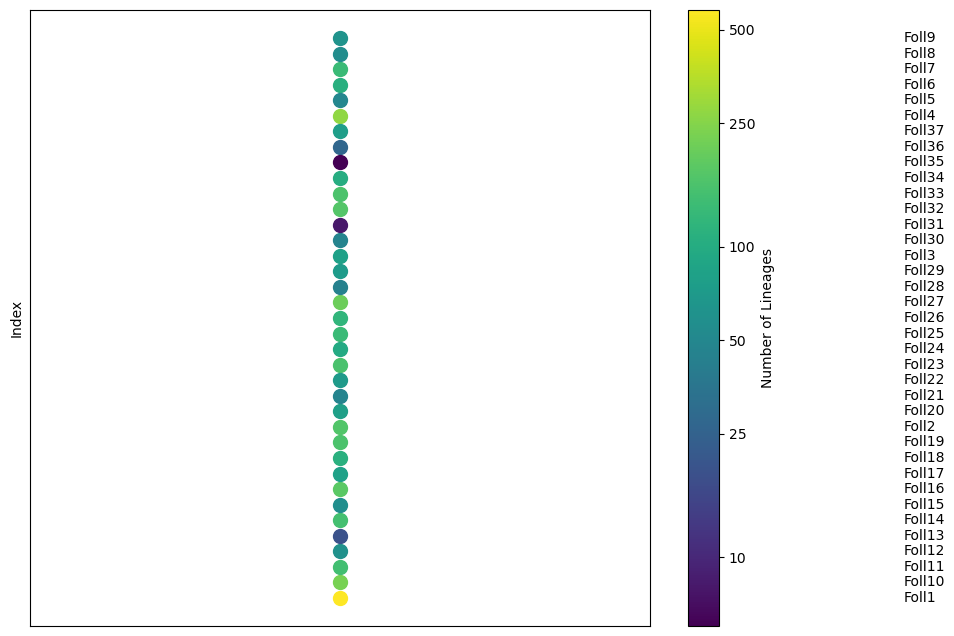

In [ ]:
# FIGURE 1A: helper colormap

# Normalize the number of lineages to the range [0, 1] for color mapping
norm = plt.Normalize(np.log(foll_stats['n_lineages'].min()), np.log(foll_stats['n_lineages'].max()))
cmap = plt.cm.viridis

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each follicle as a colored circle
for idx, row in foll_stats.iterrows():
    color = cmap(norm(np.log(row['n_lineages'])))
    ax.plot(0, idx, 'o', markersize=10, color=color)
    ax.text(0.1, idx, row['follicle'], verticalalignment='center')

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of Lineages')
# Set color bar ticks
cbar.set_ticks(np.log([10,25,50,100,250,500]))
cbar.set_ticklabels(['10', '25', '50','100','250','500'])

# Remove x-axis and y-axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Set axis labels
ax.set_ylabel('Index')

plt.savefig(r'Figures\1A_Helper_Colormap.pdf', format='pdf')

plt.show()

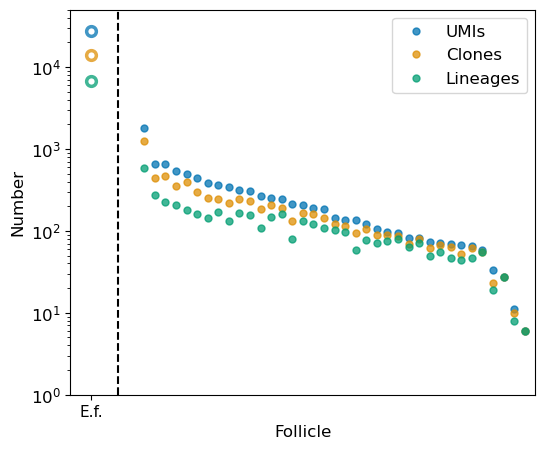

In [ ]:
# FIGURE 1B: Plot of follicle statistics

palette = sb.color_palette("colorblind", 3)
colors = [palette[0], palette[1], palette[2]]

plt.figure(figsize=(6, 5))

plt.plot(np.array(foll_stats['n_UMIs']),marker = 'o',label = 'UMIs',alpha = 0.75,color=colors[0],markersize=5,linestyle='None')
plt.plot(np.array(foll_stats['n_clones']),marker = 'o',label = 'Clones',alpha = 0.75,color=colors[1],markersize=5,linestyle='None')
plt.plot(np.array(foll_stats['n_lineages']),marker = 'o',label = 'Lineages',alpha = 0.75,color=colors[2],markersize=5,linestyle='None')

plt.plot([-5], EF_stats[0], marker='o', markerfacecolor='none', color=colors[0], alpha=0.75, markersize=7, markeredgewidth=2.5)
plt.plot([-5], EF_stats[1], marker='o', markerfacecolor='none', color=colors[1], alpha=0.75, markersize=7, markeredgewidth=2.5)
plt.plot([-5], EF_stats[2], marker='o', markerfacecolor='none', color=colors[2], alpha=0.75, markersize=7, markeredgewidth=2.5)

plt.plot([-2.5,-2.5],[1,10**4.7],color='black',linestyle='--',linewidth=1.5)


plt.yscale('log')
plt.xticks([-5], ['E.f.'],fontsize=11)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12,loc='upper right')
plt.xlabel('Follicle',fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.ylim([1,10**4.7])
plt.xlim([-7,len(foll_stats)])

plt.savefig(r'Figures\1B_Follicle_Stats.pdf', format='pdf')

plt.show()

0.25442280131619116


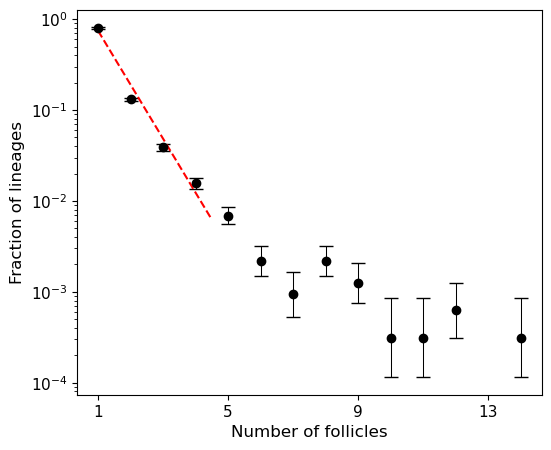

In [ ]:
# FIGURE 1C: Lineage sharing between follicles

plt.figure(figsize=(6, 5))

x, y, y_err = pdf_histogram(lineage_stats['n_follicles'], np.arange(1,np.max(lineage_stats['n_follicles'])+2))

popt, pcov = curve_fit(geometric_pdf, x[:4], np.log(y[:4]),p0=0.5)
prob = popt[0]
print(prob)

x_fit = np.linspace(x[0],(x[3]+x[4])/2,1000)
y_fit = geometric_pdf(x_fit,prob,logY=False)

# Fit a Poisson distribution to the first four points
#popt_poisson, _ = curve_fit(lambda k, mu: np.log(poisson.pmf(k-1, mu)), x[:4], np.log(y[:4]), p0=[1.0])
#mu = popt_poisson[0]
#print(mu)

# Generate the Poisson fit
#x_poisson = np.arange(1, np.max(x[:4]) + 1)
#y_poisson = poisson.pmf(x_poisson-1, mu)

# Plot the Poisson fit
#plt.plot(x_poisson, y_poisson, color='blue', linestyle='--', label='Poisson fit')

plt.errorbar(x,y,log_error_bar(y,y_err),marker='o',color='black',capsize=5,linestyle='none',linewidth=0.75)
plt.plot(x_fit,y_fit,color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('Number of follicles',fontsize=12)
plt.ylabel('Fraction of lineages',fontsize=12)
plt.xticks([1,5,9,13],fontsize=11)
plt.yticks(fontsize=11)

plt.savefig(r'Figures\1C_Lineage_Spreading.pdf', format='pdf')

plt.show()

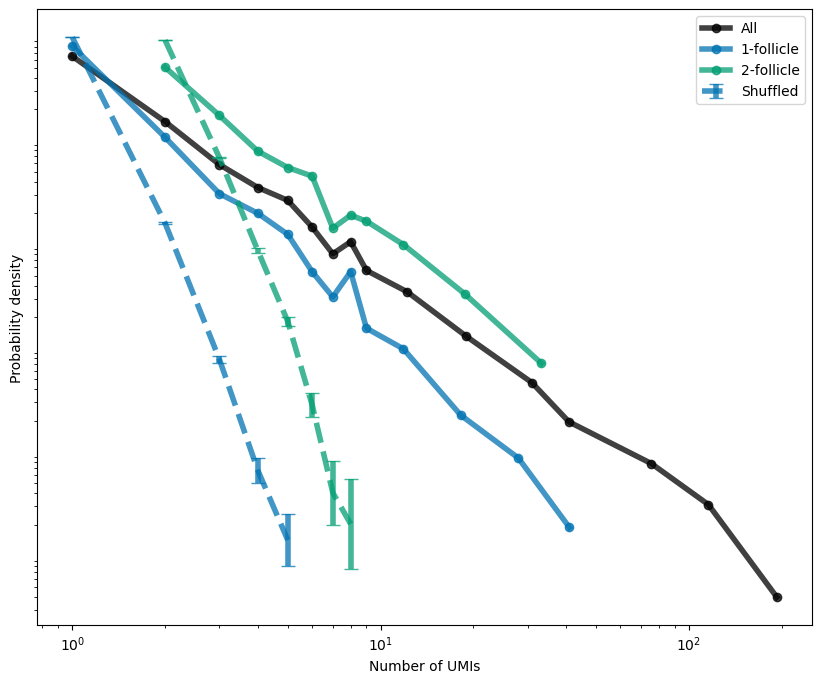

In [ ]:
# FIGURE 1E: Lineage size distributions for real and shuffled data

# Shuffled lineage stats
n_shuffles = 100
shuffled_list = []
for i in range(n_shuffles):
    df_IGH_IF_shuffled = df_IGH_IF.copy()
    df_IGH_IF_shuffled['follicle'] = np.random.permutation(df_IGH_IF_shuffled['follicle'].values)

    lin_stats_shuffled = df_IGH_IF_shuffled.groupby('lineage_id').agg(
        n_UMIs=('lineage_id', 'size'),
        n_follicles=('follicle', 'nunique')
    ).reset_index()
    shuffled_list.append(lin_stats_shuffled)

shuffled_1foll = []
shuffled_2foll = []
shuffled_3foll = []
for i in range(n_shuffles):
    lin_stats_shuffled = shuffled_list[i]
    shuffled_1foll += list(lin_stats_shuffled[lin_stats_shuffled['n_follicles'] == 1]['n_UMIs'])
    shuffled_2foll += list(lin_stats_shuffled[lin_stats_shuffled['n_follicles'] == 2]['n_UMIs'])
    shuffled_3foll += list(lin_stats_shuffled[lin_stats_shuffled['n_follicles'] == 3]['n_UMIs'])
shuffled_1foll = np.array(shuffled_1foll)
shuffled_2foll = np.array(shuffled_2foll)
shuffled_3foll = np.array(shuffled_3foll)

n_extra_bins = 10
bin_edges = np.append(np.arange(1,10),np.exp(np.linspace(np.log(10),1+np.max(np.log(lineage_stats['n_UMIs'])),n_extra_bins)))
bin_edges[9] = 10

x_all, y_all, y_err_all = pdf_histogram(lineage_stats['n_UMIs'], bin_edges)
x_1, y_1, y_err_1 = pdf_histogram(lineage_stats[lineage_stats['n_follicles'] == 1]['n_UMIs'], bin_edges)
x_2, y_2, y_err_2 = pdf_histogram(lineage_stats[lineage_stats['n_follicles'] == 2]['n_UMIs'], bin_edges)
x_3, y_3, y_err_3 = pdf_histogram(lineage_stats[lineage_stats['n_follicles'] == 3]['n_UMIs'], bin_edges)
x_4, y_4, y_err_4 = pdf_histogram(lineage_stats[lineage_stats['n_follicles'] >= 4]['n_UMIs'], bin_edges)

x_1_shuffled, y_1_shuffled, y_err_1_shuffled = pdf_histogram(shuffled_1foll, bin_edges)
x_2_shuffled, y_2_shuffled, y_err_2_shuffled = pdf_histogram(shuffled_2foll, bin_edges)
x_3_shuffled, y_3_shuffled, y_err_3_shuffled = pdf_histogram(shuffled_3foll, bin_edges)

palette = sb.color_palette("colorblind", 4)
colors = [palette[0], palette[2]]

plt.figure(figsize=(10, 8))
plt.plot(x_all, y_all, marker='o', color='black', label='All',alpha=0.75, linewidth=4)
plt.plot(x_1, y_1, marker='o', color=colors[0], label='1-follicle',alpha=0.75, linewidth=4)
plt.plot(x_2, y_2, marker='o', color=colors[1], label='2-follicle',alpha=0.75,linewidth=4)
#plt.plot(x_3, y_3, marker='o', color=colors[2], label='3-follicle',alpha=0.75)
#plt.plot(x_4, y_4, marker='o', color='gray', label='4+-follicle',alpha=0.75)

plt.errorbar(x_1_shuffled, y_1_shuffled, log_error_bar(y_1_shuffled, y_err_1_shuffled), color=colors[0], linestyle='--', label='Shuffled',alpha=0.75,capsize=5, linewidth=4)
plt.errorbar(x_2_shuffled, y_2_shuffled, log_error_bar(y_2_shuffled, y_err_2_shuffled), color=colors[1], linestyle='--',alpha=0.75,capsize=5, linewidth=4)
#plt.errorbar(x_3_shuffled, y_3_shuffled, log_error_bar(y_3_shuffled, y_err_3_shuffled), color=colors[2], linestyle='--',alpha=0.75,capsize=5)
plt.xlabel('Number of UMIs')
plt.ylabel('Probability density')

plt.legend()

#plt.gca().add_patch(plt.Rectangle((0.9, 10**-3.5), 9.3, 1.2 - 10**-3.5, fill=False, edgecolor='gray', linewidth=1,linestyle='--'))

plt.xscale('log')
plt.yscale('log')
plt.yticks([])

plt.savefig(r'Figures\1E_UMI_Given_FollNum.pdf', format='pdf')
plt.show()

In [ ]:
# FIGURE 1F: Spatial distribution of migrations

intra_dists = np.zeros(len(df_IGH_IF)**2)
all_inter_dists = np.zeros(len(df_IGH_IF)**2)
inter_dists = np.zeros(len(df_IGH_IF)**2)
inter_dists_avg = np.zeros(len(df_IGH_IF))
k0 = 0
k1 = 0
k2 = 0
k3 = 0

grouped = df_IGH_IF.groupby('follicle')
for name, group in grouped:
    for i, row1 in group.iterrows():
        for j, row2 in group.iterrows():
            if i < j:
                intra_dists[k0] = euclidean_distance(row1, row2)
                k0 += 1

for name1, group1 in grouped:
    for name2, group2 in grouped:
        if name1 >= name2: continue
        for i, row1 in group1.iterrows():
            for j, row2 in group2.iterrows():
                all_inter_dists[k1] = euclidean_distance(row1, row2)
                k1 += 1
                if row1['lineage_id'] == row2['lineage_id']:
                    inter_dists[k2] = euclidean_distance(row1, row2)
                    k2 += 1

intra_dists = intra_dists[:k0]
all_inter_dists = all_inter_dists[:k1]
inter_dists = inter_dists[:k2]

In [ ]:
import pickle

fname = 'Preprocessed_Data/pairwise_distances.pickle'
with open(fname, 'rb') as f:
    pairwise_distances = pickle.load(f)
    intra_dists = pairwise_distances['intra_dists']
    all_inter_dists = pairwise_distances['all_inter_dists']
    inter_dists = pairwise_distances['inter_dists']

typ_intra_dist = np.median(intra_dists)
bin_edges = np.linspace(0,0.1+max(np.max(intra_dists)/typ_intra_dist, np.max(all_inter_dists)/typ_intra_dist),50)
bin_edges2 = np.linspace(0,0.1+max(np.max(intra_dists)/typ_intra_dist, np.max(all_inter_dists)/typ_intra_dist),25)


x_dist1, y_dist1, y_dist_err1 = pdf_histogram(inter_dists/typ_intra_dist, bin_edges)
x_dist2, y_dist2, y_dist_err2 = pdf_histogram(all_inter_dists/typ_intra_dist, bin_edges)

In [5]:
typ_all_inter = np.median(all_inter_dists)
print(np.sum(inter_dists >= typ_all_inter)/len(inter_dists))

0.20832426787346067


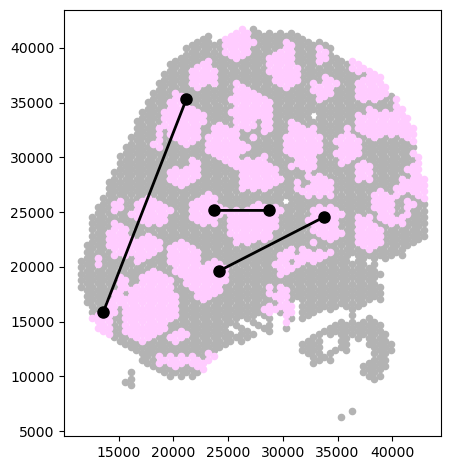

In [ ]:
section_df = metadata_df[metadata_df['section'] == '17']

for _, row in section_df.iterrows():
    x = float(row['x'])
    y = float(row['y'])
    if row['Follicles_seurat'] != 'nonFoll' and isinstance(row['Follicles_seurat'], str): continue
    plt.scatter(x, y, color=[0.7,0.7,0.7], s=20)

for _, row in section_df.iterrows():
    x = float(row['x'])
    y = float(row['y'])
    if row['Follicles_seurat'] != 'nonFoll' and isinstance(row['Follicles_seurat'], str):
        plt.scatter(x, y, color=[1,0.8,1], s=20)

x1A,y1A = 23701, 25161
x2A,y2A = 28750, 25158

x1B, y1B = 24202, 19647
x2B,y2B = 33799, 24574

x1C, y1C = 21183, 35320
x2C,y2C = 13596, 15882

plt.plot([x1A,x2A],[y1A,y2A],color='black',marker='o',markersize=8,linewidth=2)
plt.plot([x1B,x2B],[y1B,y2B],color='black',marker='o',markersize=8,linewidth=2)
plt.plot([x1C,x2C],[y1C,y2C],color='black',marker='o',markersize=8,linewidth=2)

plt.gca().set_aspect('equal', 'box')

plt.tight_layout()

plt.savefig(r'Figures\1F_Examples_Combined.pdf', format='pdf')

plt.show()

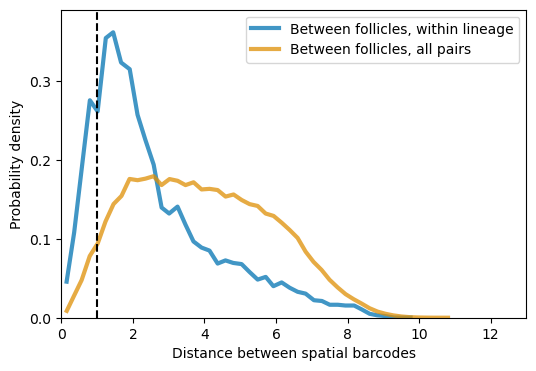

In [ ]:
palette = sb.color_palette("colorblind", 4)
colors = [palette[0], palette[1]]

plt.figure(figsize=(6, 4))

plt.plot(x_dist1, y_dist1, color=colors[0], label='Between follicles, within lineage',alpha=0.75,linewidth=3)
plt.plot(x_dist2, y_dist2, color=colors[1], label='Between follicles, all pairs',alpha=0.75,linewidth=3)

plt.plot([1,1],[0,0.39],color='black',linestyle='--',linewidth=1.5)

plt.xlabel('Distance between spatial barcodes')
plt.ylabel('Probability density')
plt.legend()
plt.ylim([0,0.39])
plt.yticks([0,0.1,0.2,0.3])
plt.xlim([0,13])

plt.savefig(r'Figures\1F_Migration_Distance.pdf', format='pdf')

plt.show()


In [ ]:
# FIGURE 1G-H: Spatial distribution of B cell and T cell clones

fname = 'Data/Preprocessed_Data/pairwise_distances.pickle'
with open(fname, 'rb') as f:
    pairwise_distances = pickle.load(f)
    intra_dists = pairwise_distances['intra_dists']
    all_inter_dists = pairwise_distances['all_inter_dists']
    inter_dists = pairwise_distances['inter_dists']

typ_intra_dist = np.median(intra_dists)

all_inter_dists_cb = np.zeros(len(df_IGH_IF)**2)
inter_dists_cb = np.zeros(len(df_IGH_IF)**2)
k1 = 0
k2 = 0

grouped = df_IGH_IF.groupby('v_sequence_no_trunc')

for seq1, group1 in grouped:
    div_from_root = int(group1.iloc[0]['v_mismatch'])/len(seq1)
    if len(group1) < 2 or div_from_root < 0.01: continue
    for seq2, group2 in grouped:
        div_from_root = int(group2.iloc[0]['v_mismatch'])/len(seq2)
        if len(group2) < 2 or div_from_root < 0.01: continue
        for i, row1 in group1.iterrows():
            for j, row2 in group2.iterrows():
                if (seq1 < seq2 or (seq1 == seq2 and i < j)) and row1['follicle'] != row2['follicle']:
                    all_inter_dists_cb[k1] = euclidean_distance(row1, row2)
                    k1 += 1

for seq, group in grouped:
    div_from_root = int(group.iloc[0]['v_mismatch'])/len(seq)
    if len(group) < 2 or div_from_root < 0.01: continue
    for i, row1 in group.iterrows():
        for j, row2 in group.iterrows():
            if i < j:
                if row1['follicle'] != row2['follicle']:
                    inter_dists_cb[k2] = euclidean_distance(row1, row2)
                    k2 += 1

all_inter_dists_cb = all_inter_dists_cb[:k1]
inter_dists_cb = inter_dists_cb[:k2]

In [ ]:
fname = 'Data/Preprocessed_Data/pairwise_distances.pickle'
with open(fname, 'rb') as f:
    pairwise_distances = pickle.load(f)
    intra_dists = pairwise_distances['intra_dists']
    all_inter_dists = pairwise_distances['all_inter_dists']
    inter_dists = pairwise_distances['inter_dists']

typ_intra_dist = np.median(intra_dists)

from scipy.spatial.distance import pdist

df_TRB_IF = df_TRB[
    (df_TRB['Follicles_seurat'] != 'nonFoll') &
    (df_TRB['Follicles_seurat'].apply(lambda x: isinstance(x, str)))
]

dist_list_full = []
dist_list = []
dist_list_avg = []
for clone_id in df_TRB_IF['cloneId'].unique():
    dist_list_temp = []
    subset = df_TRB_IF[df_TRB_IF['cloneId'] == clone_id]
    if len(subset) > 1:
        for i, row1 in subset.iterrows():
            for j, row2 in subset.iterrows():
                if i <= j or row1['Follicles_seurat'] == row2['Follicles_seurat']: continue
                dist = np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)
                dist_list_temp.append(dist)
    if len(dist_list_temp) > 0:
        dist_list.extend(dist_list_temp)
        dist_list_avg.append(np.mean(dist_list_temp))
dist_list = np.array(dist_list)/typ_intra_dist
dist_list_avg = np.array(dist_list_avg)/typ_intra_dist

for foll in df_TRB_IF['Follicles_seurat'].unique():
    for foll2 in df_TRB_IF['Follicles_seurat'].unique():
        if foll >= foll2: continue
        subset1 = df_TRB_IF[df_TRB_IF['Follicles_seurat'] == foll]
        subset2 = df_TRB_IF[df_TRB_IF['Follicles_seurat'] == foll2]
        for i, row1 in subset1.iterrows():
            for j, row2 in subset2.iterrows():
                dist = np.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)
                dist_list_full.append(dist)
dist_list_full = np.array(dist_list_full)/typ_intra_dist



In [ ]:
fname = 'Data/Preprocessed_Data/pairwise_distances_clonal_bursts.pickle'

with open(fname, 'rb') as f:
    pairwise_distances_cb = pickle.load(f)
    all_inter_dists_cb = pairwise_distances_cb['all_inter_dists_cb']
    inter_dists_cb = pairwise_distances_cb['inter_dists_cb']

fname = 'Data/Preprocessed_Data/T_cell_distance.pickle'
with open(fname, 'rb') as f:
    data = pickle.load(f)
    dist_list_full = data['dist_list_full']
    dist_list = data['dist_list']

max_bin = max(max(dist_list_full),np.max(all_inter_dists_cb)/typ_intra_dist)
bins = np.linspace(0, max_bin+0.1, 30)

x1, y1, _ = pdf_histogram(inter_dists_cb/typ_intra_dist, bins)
x2, y2, _ = pdf_histogram(all_inter_dists_cb/typ_intra_dist, bins)
x3, y3, _ = pdf_histogram(dist_list_full[dist_list_full>0], bins)
x4, y4, _ = pdf_histogram(dist_list[dist_list>0], bins)

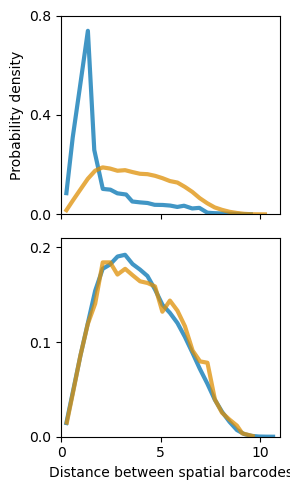

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(3, 5), sharex=True)

palette = sb.color_palette("colorblind", 4)
colors = [palette[0], palette[1]]

# Top subplot
axs[0].plot(x1, y1, color=colors[0], label='Between follicles, within lineage', alpha=0.75, linewidth=3)
axs[0].plot(x2, y2, color=colors[1], label='Between follicles, all pairs', alpha=0.75, linewidth=3)
axs[0].set_ylabel('Probability density')
axs[0].set_ylim([0, 0.8])
axs[0].set_xlim([0, 11])
axs[0].set_yticks([0,0.4,0.8])

# Bottom subplot
axs[1].plot(x3, y3, color=colors[0], label='Between follicles, within lineage', alpha=0.75, linewidth=3)
axs[1].plot(x4, y4, color=colors[1], label='Between follicles, all pairs', alpha=0.75, linewidth=3)
axs[1].set_xlabel('Distance between spatial barcodes')
axs[1].set_xlim([0, 11])
axs[1].set_ylim([0, 0.21])
axs[1].set_yticks([0,0.1,0.2])
axs[1].set_xticks([0,5,10])


plt.tight_layout()

plt.savefig(r'Figures\1G_Clonal_Spatial_Distribution.pdf', format='pdf')

plt.show()

0.06993006993006994
0.02703484357544621


c:\Users\johnd\OneDrive\Desktop\Stanford\Good Lab\Germinal_Centers\GC_Code\data_analysis_utils.py:70: RuntimeWarning: invalid value encountered in log
  ans = -x/X0 - np.log(X0) if logY else np.exp(-x/X0)/X0


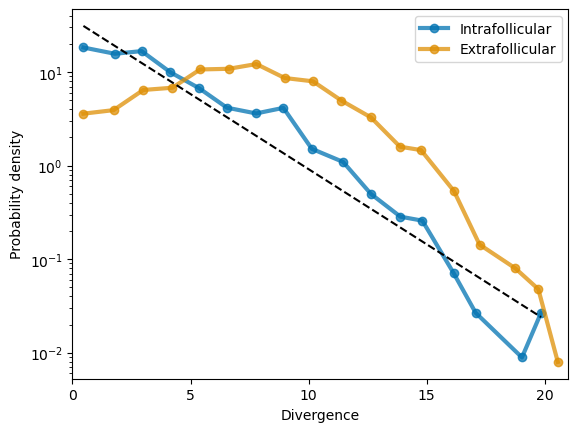

In [ ]:
# FIGURE 2B: Distribution of hypermutation counts

palette = sb.color_palette("colorblind", 2)
colors = [palette[0], palette[1]]

n_muts_IF = np.array(df_IGH_IF['v_mismatch']).astype(int)/np.array([len(seq) for seq in df_IGH_IF['v_sequence_no_trunc']])
n_muts_EF = np.array(df_IGH_EF_PBdom['v_mismatch']).astype(int)/np.array([len(seq) for seq in df_IGH_EF_PBdom['v_sequence_no_trunc']])
print(np.median(n_muts_EF))
bins = np.linspace(0,max(np.max(n_muts_IF), np.max(n_muts_EF)), 20)

x, y, y_err = pdf_histogram(n_muts_IF,bins)
x2, y2, y_err2 = pdf_histogram(n_muts_EF,bins)

popt, pcov = curve_fit(expon_pdf, x, np.log(y),p0=0.1)
prob = popt[0]
print(prob)

x_fit = np.linspace(x[0],(x[3]+x[4])/2,1000)
y_fit = geometric_pdf(x_fit,prob,logY=False)

plt.plot(x, y, color=colors[0], label='Intrafollicular',alpha=0.75,linewidth=3,marker='o')
plt.plot(x2, y2, color=colors[1], label='Extrafollicular',alpha=0.75,linewidth=3,marker='o')

err1 = log_error_bar(y,y_err)
err2 = log_error_bar(y2,y_err2)

plt.plot(x,expon_pdf(x,prob,logY=False),linestyle='--',color='black')


plt.yscale('log')
plt.xlabel('Divergence')
plt.ylabel('Probability density')
plt.legend()
plt.xlim([0,0.21])
plt.xticks([0,0.05,0.1,0.15,0.2],['0','5','10','15','20'])

plt.savefig(r'Figures\2B_Divergence_Distribution.pdf', format='pdf')

plt.show()

In [38]:
# FIGURE 2C: Migration probability as function of divergence

shared_same = []
shared_cross = []
unique_same = []
unique_cross = []

#lineage_counts = filtered_df['lineage_id'].value_counts()
lineage_counts = df_IGH_IF['lineage_id'].value_counts()
repeated_lineages = lineage_counts[lineage_counts > 1].index

for lineage_id in repeated_lineages:
    lineage_df = df_IGH_IF[df_IGH_IF['lineage_id'] == lineage_id]
    lineage_df = lineage_df.drop_duplicates(subset=['follicle', 'v_mutations'])
    for index1, row1 in lineage_df.iterrows():
        for index2, row2 in lineage_df.iterrows():
            if index1 >= index2:
                continue
            n1, n2, n3 = pairwise_helper(row1['v_mutations'], row2['v_mutations'], skip_same=True, tot_len = (len(row1['v_sequence_no_trunc'])+len(row2['v_sequence_no_trunc']))/2 )
            if n1 == -1:
                continue
            if row1['follicle'] == row2['follicle']:
                shared_same.append(n1)
                unique_same.append(n2+n3)
            else:
                shared_cross.append(n1)
                unique_cross.append(n2+n3)

unique_same = np.array(unique_same)
unique_cross = np.array(unique_cross)
shared_same = np.array(shared_same)
shared_cross = np.array(shared_cross)

3.6391298424991834


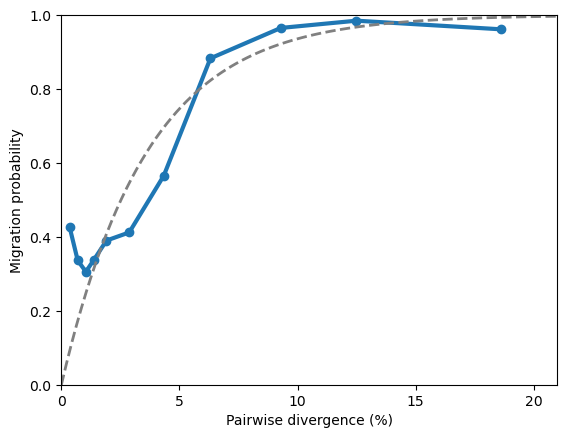

In [ ]:
from scipy.optimize import curve_fit

bins = np.logspace(np.log10(min(np.min(unique_same), np.min(unique_cross))), np.log10(0.01+max(np.max(unique_same), np.max(unique_cross))),12)
divs = np.zeros(len(bins)-1)
p_cross = np.zeros(len(bins)-1)
p_cross_err = np.zeros(len(bins)-1)

for i in range(0,len(bins)-1):
    mask_cross = np.logical_and(unique_cross >= bins[i], unique_cross < bins[i+1])
    mask_same = np.logical_and(unique_same >= bins[i], unique_same < bins[i+1])

    p_cross[i] = np.sum(mask_cross)/(np.sum(mask_same)+np.sum(mask_cross))
    p_cross_err[i] = np.sqrt(np.sum(mask_cross))/(np.sum(mask_same)+np.sum(mask_cross))
    divs[i] = 100 * ( np.mean(unique_cross[mask_cross])*np.sum(mask_cross) + np.mean(unique_same[mask_same])*np.sum(mask_same) ) / (np.sum(mask_same) + np.sum(mask_cross))

# Define the exponential function
def exp_func(t, a):
    return 1 - np.exp(-t/a)

# Fit the exponential function to the data
popt, pcov = curve_fit(exp_func, divs, p_cross)
a = popt[0]

# Generate fitted data
t_fit = np.linspace(0, 21, 100)
p_fit = exp_func(t_fit, a)

# Plot the fitted curve
plt.plot(divs,p_cross,marker='o',linewidth=3)
plt.plot(t_fit, p_fit, label=f'Fit: 1 - exp(-{a:.2f} * t)', color=[0.5,0.5,0.5],linestyle='--',linewidth=2)

#plt.xscale('log')
plt.xlabel('Pairwise divergence (%)')
plt.ylabel('Migration probability')
plt.ylim([0,1])
plt.xlim([0,21])
plt.xticks([0,5,10,15,20])
print(a)

plt.savefig(r'Figures\2C_Migration_Probability.pdf', format='pdf')

plt.show()

In [ ]:
# FIGURE 2D: Clonal burst analysis

sequence_info = []

for sequence in df_combined['v_sequence_no_trunc'].unique():
    subset = df_combined[df_combined['v_sequence_no_trunc'] == sequence]
    num_appearances = len(subset)
    num_distinct_follicles = subset[subset['follicle'] != 'EF']['follicle'].nunique()
    div_from_root = int(subset.iloc[0]['v_mismatch'])/len(sequence)
    num_appearances_EF = len(subset[subset['follicle'] == 'EF'])

    prob_distinct = 0
    if num_distinct_follicles > 1:
        foll_list = subset[subset['follicle'] != 'EF']['follicle'].unique()
        for foll1 in range(len(foll_list)):
            for foll2 in range(foll1+1, len(foll_list)):
                prob_distinct += 2 * len(subset[subset['follicle'] == foll_list[foll1]])/(num_appearances - num_appearances_EF) * len(subset[subset['follicle'] == foll_list[foll2]])/(num_appearances - num_appearances_EF - 1)

    sequence_info.append([sequence, num_appearances-num_appearances_EF, num_distinct_follicles, div_from_root, num_appearances_EF, prob_distinct])

clonal_burst_df = pd.DataFrame(sequence_info, columns=['v_sequence_no_trunc', 'num_appearances_IF', 'num_distinct_follicles', 'div_from_root', 'num_appearances_EF', 'prob_distinct'])
clonal_burst_df = clonal_burst_df[clonal_burst_df['num_appearances_IF'] + clonal_burst_df['num_appearances_EF'] >= 2]
clonal_burst_df = clonal_burst_df[clonal_burst_df['div_from_root'] > 0.01]


0.07348876428186313


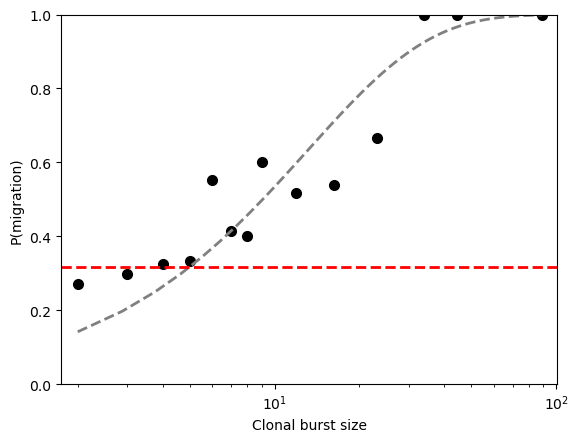

In [ ]:
from scipy.optimize import curve_fit

mask = clonal_burst_df['num_appearances_IF'] >= 2
overall_prob = np.sum(clonal_burst_df[mask]['num_distinct_follicles'] > 1)/np.sum(mask)

bins = np.array([2,3,4,5,6,7,8,9,10,15,20,30,40,60,120])
x = np.zeros(len(bins)-1)
p_migration = np.zeros(len(bins)-1)
p_migration_err = np.zeros(len(bins)-1)

p_migration2 = np.zeros(len(bins)-1)
x2 = np.zeros(len(bins)-1)

for i in range(0,len(bins)-1):
    mask = np.logical_and(clonal_burst_df['num_appearances_IF'] >= bins[i], clonal_burst_df['num_appearances_IF'] < bins[i+1])
    p_migration[i] = np.sum(clonal_burst_df[mask]['num_distinct_follicles'] > 1)/np.sum(mask)
    p_migration_err[i] = np.sqrt(np.sum(clonal_burst_df[mask]['num_distinct_follicles'] > 1))/np.sum(mask)
    x[i] = np.mean(clonal_burst_df[mask]['num_appearances_IF'])

    mask = np.logical_and(lineage_stats['n_UMIs'] >= bins[i], lineage_stats['n_UMIs'] < bins[i+1])
    p_migration2[i] = np.sum(lineage_stats[mask]['n_follicles'] > 1)/np.sum(mask)
    x2[i] = np.mean(lineage_stats[mask]['n_UMIs'])

plt.plot(x,p_migration,marker='o',linewidth=3,linestyle='none',markersize=7,color='black')
#plt.plot(x2,p_migration2,marker='o',linestyle='none',color='blue')
plt.ylim([0,1])
plt.xscale('log')
plt.xlabel('Clonal burst size')
plt.ylabel('P(migration)')

# Define the function to fit
def fit_func(x, alpha):
    return 1 - alpha**(x)

# Fit the curve
popt, pcov = curve_fit(fit_func, x, p_migration, p0=0.5)
alpha = popt[0]

# Generate fitted data
x_fit = np.linspace(min(x), max(x), 100)
y_fit = fit_func(x_fit, alpha)

# Plot the fitted curve
plt.plot(x_fit, y_fit, label=f'Fit: 1 - {alpha:.2f}^x', color=[0.5,0.5,0.5], linestyle='--',linewidth=2)
plt.plot([1.75,101],[overall_prob,overall_prob],color='red',linestyle='--',linewidth=2)
plt.xlim([1.75,101])
print(1-alpha)

plt.savefig(r'Figures\2D_Clonal_Bursts.pdf', format='pdf')

plt.show()

In [ ]:
# FIGURE 3B: Migration counts from trees

foll_names = df_IGH_IF['follicle'].unique()

migration_count = np.zeros((len(lineage_ids), len(foll_names), len(foll_names)), dtype=int)
migration_denoms = np.zeros((len(lineage_ids), len(foll_names)))
branch_start_ends_mig = None

for ind in range(len(lineage_ids)):
    lin_id = int(float(lineage_ids[ind]))
    tree = Phylo.read("Data/Lineage_Seqs/Lineage_Trees/tree_lin_" + str(lin_id) + "_no_ef.newick", "newick")

    root_flag = False
    for clade in tree.find_clades():
        if clade.name and clade.name.startswith("ROOT"):
            tree.root_with_outgroup(clade)
            if clade.name == "ROOT__INFERRED": tree.collapse(clade)
            root_flag = True
            break
    if not root_flag: print("Error: No root found")

    label_tips(tree, df_IGH_IF, lineage_ids[ind], ignore_EF = True)
    fill_internal_nodes(tree, lineage_ids[ind], df_IGH_IF, track_dominant = True)
    
    #visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True)

    branches = get_branch_annotations(tree)

    tot_migrations = 0
    tot_branch_len = 0
    for branch in branches:
        if branch['branch_length'] == 0: continue

        par_ind = np.argmax(foll_names == branch['parent_foll'])
        child_ind = np.argmax(foll_names == branch['child_foll'])
        migration_denoms[ind, par_ind] += branch['branch_length']

        if branch['parent_foll'] != branch['child_foll']:
            migration_count[ind,par_ind,child_ind] += 1
            branch_data = np.array([branch['parent_depth'], branch['parent_depth']+branch['branch_length'], 1])
        else:
            branch_data = np.array([branch['parent_depth'], branch['parent_depth']+branch['branch_length'], 0])

        if branch_start_ends_mig is None:
            branch_start_ends_mig = branch_data
        else:
            branch_start_ends_mig = np.vstack((branch_start_ends_mig, branch_data))


14.449397683986179
R^2: 0.550


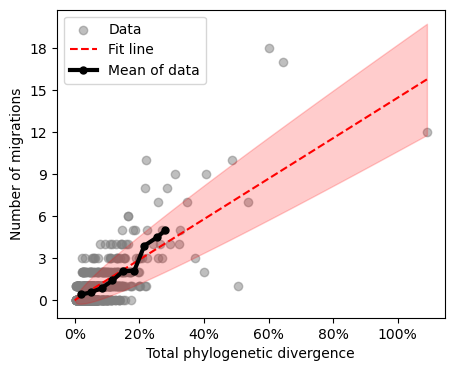

In [ ]:
from scipy.optimize import curve_fit

lin_denoms = np.sum(migration_denoms, axis=1)
migration_ct_lins = np.sum(migration_count, axis=(1,2))

plt.figure(figsize=(5, 4))
bin_edges = np.linspace(0.003, 0.3, 10)

x = np.zeros(len(bin_edges)-1)
mean_migs = np.zeros(len(bin_edges)-1)
mean_mig_err = np.zeros(len(bin_edges)-1)

for i in range(len(mean_migs)):
    mask = np.logical_and(lin_denoms>= bin_edges[i], lin_denoms < bin_edges[i+1])
    if sum(mask) <= 1: continue

    x[i] = np.mean(lin_denoms[mask])
    mean_migs[i] = np.mean(migration_ct_lins[mask])
    mean_mig_err[i] = np.std(migration_ct_lins[mask]) / np.sqrt(len(migration_ct_lins[mask]))

plt.scatter(lin_denoms, migration_ct_lins, alpha=0.5,color='gray',label='Data')

def linear_func(x, m):
    return m * x
popt, pcov = curve_fit(linear_func, lin_denoms, migration_ct_lins)
m_fit = popt[0]
print(m_fit)

# Calculate R^2 for the linear fit
residuals = migration_ct_lins - linear_func(lin_denoms, m_fit)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((migration_ct_lins - np.mean(migration_ct_lins))**2)
r2 = 1 - ss_res / ss_tot
print(f"R^2: {r2:.3f}")

plt.plot([0,np.max(lin_denoms)], [0,m_fit*np.max(lin_denoms)], color='red', linestyle='--', label='Fit line')
# Shade the region y = m_fit * x ± sqrt(m_fit * x)
x_shade = np.linspace(0, np.max(lin_denoms), 200)
y_shade = m_fit * x_shade
y_shade_err = np.sqrt(m_fit * x_shade)
plt.fill_between(x_shade, y_shade - y_shade_err, y_shade + y_shade_err, color='red', alpha=0.2)
plt.plot(x[x>0],mean_migs[x>0],marker='o',color='black',label = 'Mean of data',markersize=5,linewidth=3)

plt.xlabel('Total phylogenetic divergence')
plt.ylabel('Number of migrations')
plt.yticks([0,3,6,9,12,15,18])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.legend()

#plt.savefig(r'Figures\3B_Migrations_Clock_Time.pdf', format='pdf')

plt.show()

In [12]:
# FIGURE 3C: Migration rate survival function

tot_ct = np.sum(migration_count,axis=(1,2))
tot_denom = np.sum(migration_denoms,axis=1)
frac_monofoll = np.sum(tot_ct == 0) / len(tot_ct)

filt = tot_ct >= 1

tot_ct = tot_ct[filt]
tot_denom = tot_denom[filt]

tau_ests1 = np.zeros((len(tot_ct), 3))

for i in range(len(tot_ct)): tau_ests1[i] = poiss_CI(tot_ct[i], tot_denom[i])

tot_ct = np.sum(migration_count,axis=(0,2))
tot_denom = np.sum(migration_denoms,axis=0)
filt = tot_ct >= 1

tot_ct = tot_ct[filt]
tot_denom = tot_denom[filt]

tau_ests2 = np.zeros((len(tot_ct), 3))

for i in range(len(tot_ct)): tau_ests2[i] = poiss_CI(tot_ct[i], tot_denom[i])

Error (101, 8.379370000000002, 0.05) [-2.99746545] <function poiss_CI.<locals>.eq1 at 0x000001DB20113310>
Error (59, 4.03481, 0.05) [-3.18578479] <function poiss_CI.<locals>.eq1 at 0x000001DB20113310>


In [13]:
from scipy.interpolate import interp1d

tot_ct = np.sum(migration_count,axis=(1,2))
tot_denom = np.sum(migration_denoms,axis=1)
filt = tot_ct >= 1

err_bar_filt = np.logical_and(tot_ct[filt] < 2, 1/tau_ests1[:,0] > np.percentile(1/tau_ests1[:,0],90))

tot_denom = np.sum(migration_denoms,axis=1)
all_filt = np.ones(len(tot_ct), dtype=bool)
ct = 0
for i in range(len(tot_ct)):
    if filt[i]:
        if err_bar_filt[ct]: all_filt[i] = False
        ct += 1
mig_denoms_filt = tot_denom[all_filt]

rate_values_filt = 1/tau_ests1[np.logical_not(err_bar_filt),0]

rate_inferred_filt = fit_survival_func_single_rate(rate_values_filt, mig_denoms_filt, np.exp(np.mean(np.log(rate_values_filt))), points_side=20, plot_fit=False)

x_vals_filt = np.logspace(np.log10(rate_values_filt.min()), np.log10(rate_values_filt.max()), 500)
surv_sampled_mean_filt, surv_sampled_std_filt, _, _ = get_survival_func_single_rate(mig_denoms_filt, rate_inferred_filt, x_vals_filt)

rates_data_sorted_filt, survival_data_filt = surv_func(rate_values_filt)


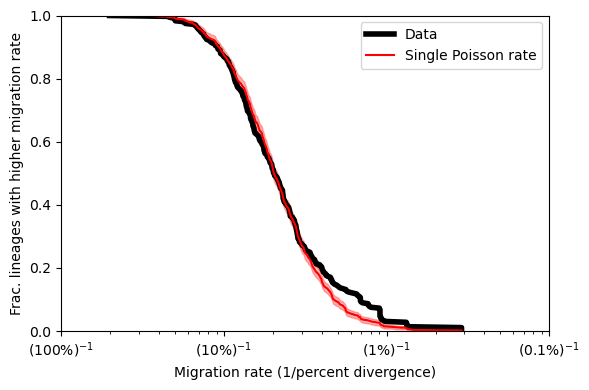

In [ ]:
rate_values = 1/tau_ests1[:,0]

rate_inferred = fit_survival_func_single_rate(rate_values, lin_denoms, np.exp(np.mean(np.log(rate_values))), points_side = 20, plot_fit = False)

x_vals = np.logspace(np.log10(rate_values.min()), np.log10(rate_values.max()), 500)
surv_sampled_mean, surv_sampled_std, frac_monofoll_sampled, mig_numbers_sampled = get_survival_func_single_rate(lin_denoms, rate_inferred, x_vals)

rates_data_sorted, survival_data = surv_func(rate_values)

plt.figure(figsize=(6, 4))
plt.plot(rates_data_sorted, survival_data, color='black', label='Data',linewidth=4)

#plt.fill_between(x_common, np.minimum(y_lower, y_upper), np.maximum(y_lower, y_upper), color='gray', alpha=0.3)
plt.plot(x_vals, surv_sampled_mean, color='red', linewidth=1.5,label='Single Poisson rate')
plt.fill_between(x_vals, surv_sampled_mean - surv_sampled_std, surv_sampled_mean + surv_sampled_std, color='red', alpha=0.3)

plt.xscale('log')

plt.xticks([1, 10, 100, 1000], [r'$(100\%)^{-1}$',r'$(10\%)^{-1}$', r'$(1\%)^{-1}$', r'$(0.1\%)^{-1}$'])
plt.legend()
plt.xlabel('Migration rate (1/percent divergence)')
plt.ylabel('Frac. lineages with higher migration rate')
plt.ylim([0,1])
plt.tight_layout()

#plt.savefig(r'Figures\3C_Migration_Rate_Survival.pdf', format='pdf')

plt.show()

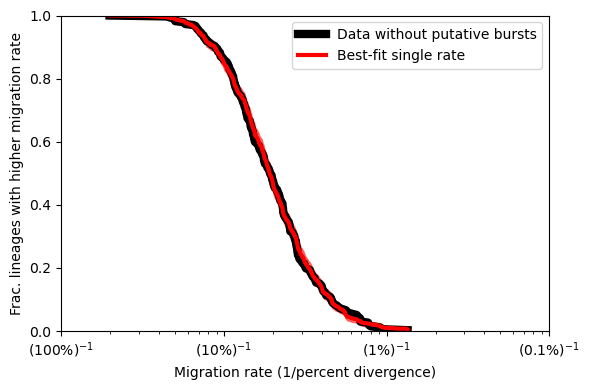

In [ ]:
# FIGURE 3C inset: Migration counts from trees (filtered)

plt.figure(figsize=(6, 4))

plt.plot(rates_data_sorted_filt, survival_data_filt, color='black', label='Data without putative bursts', linewidth=6)
plt.plot(x_vals_filt, surv_sampled_mean_filt, color='red', linewidth=3, label='Best-fit single rate')
plt.fill_between(x_vals_filt, surv_sampled_mean_filt - surv_sampled_std_filt, surv_sampled_mean_filt + surv_sampled_std_filt, color='red', alpha=0.5)

plt.xscale('log')

plt.xticks([1, 10, 100, 1000], [r'$(100\%)^{-1}$',r'$(10\%)^{-1}$', r'$(1\%)^{-1}$', r'$(0.1\%)^{-1}$'])
plt.legend()
plt.xlabel('Migration rate (1/percent divergence)')
plt.ylabel('Frac. lineages with higher migration rate')
plt.ylim([0,1])
plt.tight_layout()

plt.savefig(r'Figures\3C_Filtered_Inset.pdf', format='pdf')

plt.show()

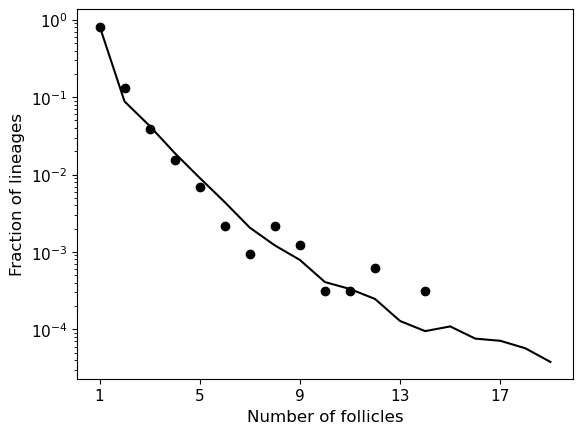

In [ ]:
# FIGURE S9: lineage size distribution under Poisson model

min_lineage_size = 2
N_lineages_tot = 0
N_trees = 0
for lineage_id, group in df_IGH.groupby('lineage_id'):
    group_trimmed = group.drop_duplicates(subset='v_mutations')
    group_trimmed = group_trimmed[group_trimmed['follicle'] != 'EF']
    if len(group_trimmed) >= min_lineage_size: N_trees += 1
    elif len(group_trimmed) == 1: N_lineages_tot += 1

mig_number_dist = mig_numbers_sampled * N_trees / N_lineages_tot
mig_number_dist[0] += (N_lineages_tot - N_trees)/N_lineages_tot
frac_monofoll_sampled = mig_number_dist[0]
frac_monofoll = frac_monofoll * N_trees / N_lineages_tot + (N_lineages_tot - N_trees)/N_lineages_tot

plt.plot(np.arange(1,len(mig_number_dist)+1), mig_number_dist,color='black',label='Poisson model')

x, y, y_err = pdf_histogram(lineage_stats['n_follicles'], np.arange(1,np.max(lineage_stats['n_follicles'])+2))

plt.plot(x,y,marker='o',color='black',linestyle='none',label='Data')

plt.yscale('log')
plt.xlabel('Number of follicles',fontsize=12)
plt.ylabel('Fraction of lineages',fontsize=12)
plt.xticks([1,5,9,13,17],fontsize=11)
plt.yticks(fontsize=11)
#plt.legend()
#plt.xscale('log')
#plt.xticks([1,2,4,8,13],['1','2','4','8','13'],fontsize=12)

plt.savefig(r'Figures\Supplementary\3D_Lineage_Spreading.pdf', format='pdf')

plt.show()

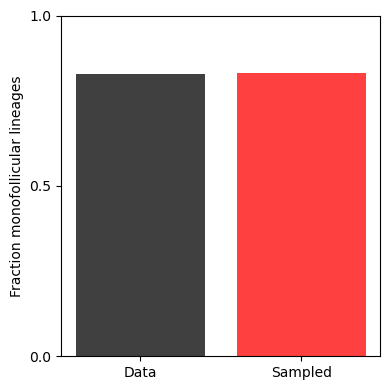

In [ ]:
plt.figure(figsize=(4, 4))
plt.bar(['Data', 'Sampled'], [frac_monofoll, np.mean(frac_monofoll_sampled)], color=['black', 'red'], alpha=0.75)

plt.ylabel('Fraction monofollicular lineages')
plt.ylim([0, 1])
plt.yticks([0,0.5,1])
plt.tight_layout()
plt.savefig(r'Figures\3D_Inset_Prop_Mono.pdf', format='pdf')

plt.show()

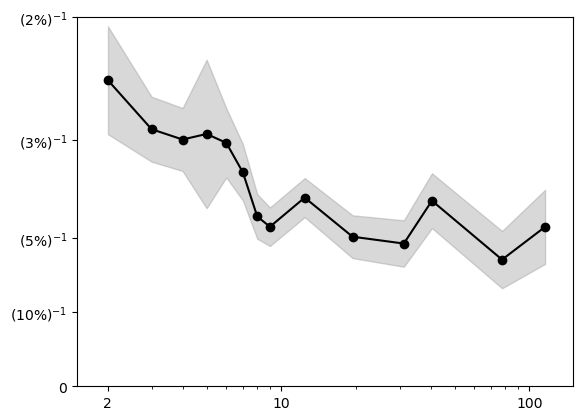

In [ ]:
# FIGURE 4A: Migration rate vs lineage size

tot_ct = np.sum(migration_count,axis=(1,2))
tot_denom = np.sum(migration_denoms,axis=1)
filt = tot_ct >= 1

lin_sizes = np.array([np.sum(df_IGH_IF['lineage_id'] == lineage_id) for lineage_id in lineage_ids])[filt]

n_extra_bins = 10
bin_edges = np.append(np.arange(1,10),np.exp(np.linspace(np.log(10),1+np.max(np.log(lin_sizes)),n_extra_bins)))
bin_edges[9] = 10

y = np.zeros(len(bin_edges)-1)
mean_rate = np.zeros(len(bin_edges)-1)
std_rate = np.zeros(len(bin_edges)-1)

for i in range(len(mean_rate)):
    mask = np.logical_and(lin_sizes >= bin_edges[i], lin_sizes < bin_edges[i+1])
    if sum(mask) <= 1: continue

    y[i] = np.mean(lin_sizes[mask])
    mean_rate[i] = np.mean(1/tau_ests1[mask,0])
    std_rate[i] = np.std(1/tau_ests1[mask,0])/np.sqrt(sum(mask))

#plt.plot(y[y > 0],mean_rate[y > 0], marker='o', color='blue', linestyle='-', linewidth=2)


plt.plot(y[y>0], mean_rate[y > 0],color='black',marker='o')

plt.fill_between(y[y > 0], mean_rate[y > 0] - std_rate[y > 0], mean_rate[y > 0] + std_rate[y > 0], color='gray', alpha=0.3)


plt.xscale('log')
#plt.yscale('log')

plt.xticks([2,10,100],['2', '10', '100'])
#plt.yticks([100/50, 100/10, 100/1, 100/0.3], [r'$(50\%)^{-1}$',r'$(10\%)^{-1}$', r'$(1\%)^{-1}$', r'$(0.3\%)^{-1}$'])
plt.yticks([0,100/10, 100/5, 100/3, 100/2], ['0',r'$(10\%)^{-1}$', r'$(5\%)^{-1}$',r'$(3\%)^{-1}$', r'$(2\%)^{-1}$'])
plt.ylim([0,100/2])
plt.xlim([1.5,150])
plt.savefig(r'Figures\4A_Migration_Rate_Size_New.pdf', format='pdf')
plt.show()

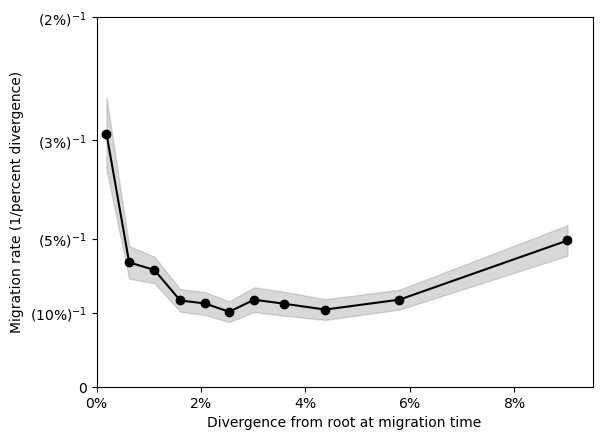

In [ ]:
# FIGURE S10A: Dependence of migration rate on lineage age

bins = np.unique(np.percentile((branch_start_ends_mig[:,0] + branch_start_ends_mig[:,1])/2,np.linspace(0,100,12)))
age_vals = np.zeros(len(bins)-1)
rate_vals = np.zeros(len(bins)-1)
rate_err_vals = np.zeros(len(bins)-1)

age_est = (branch_start_ends_mig[:,0] + branch_start_ends_mig[:,1])/2

for i in range(len(rate_vals)):
    mask = np.logical_and(age_est >= bins[i], age_est < bins[i+1])
    if np.sum(mask) == 0: continue
    age_vals[i] = np.mean(age_est[mask])
    rate_vals[i] = np.sum(branch_start_ends_mig[mask,2])/(np.sum(branch_start_ends_mig[mask,1]) - np.sum(branch_start_ends_mig[mask,0]))
    rate_err_vals[i] = np.sqrt(np.sum(branch_start_ends_mig[mask,2]))/(np.sum(branch_start_ends_mig[mask,1]) - np.sum(branch_start_ends_mig[mask,0]))

plt.plot(age_vals, rate_vals,color='black',marker='o')

plt.fill_between(age_vals, rate_vals - rate_err_vals, rate_vals + rate_err_vals, color='gray', alpha=0.3)

#plt.yscale('log')
plt.xlabel('Divergence from root at migration time')

plt.yticks([0,100/10, 100/5, 100/3, 100/2], ['0',r'$(10\%)^{-1}$', r'$(5\%)^{-1}$',r'$(3\%)^{-1}$', r'$(2\%)^{-1}$'])
plt.xticks([0,0.02,0.04,0.06,0.08], [r'$0\%$',r'$2\%$',r'$4\%$',r'$6\%$',r'$8\%$'])
plt.ylabel('Number of UMIs in lineage')
plt.ylabel('Migration rate (1/percent divergence)')
plt.xlim([0,0.095])

plt.savefig(r'Figures\Supplementary\4B_Lineage_Age_Migration.pdf', format='pdf')

plt.show()

In [ ]:
# FIGURE 4A: Analysis of divergence after migration


for ind in range(len(lineage_ids)):

    lin_id = lineage_ids[ind]
    tree = Phylo.read("Data/Lineage_Seqs/Lineage_Trees/tree_lin_" + str(lin_id) + "_no_ef.newick", "newick")

    root_flag = False
    for clade in tree.find_clades():
        if clade.name and clade.name.startswith("ROOT"):
            tree.root_with_outgroup(clade)
            if clade.name == "ROOT__INFERRED": tree.collapse(clade)
            root_flag = True
            break
    if not root_flag: print("Error: No root found")

    label_tips(tree, df_IGH_IF, lineage_ids[ind], ignore_EF = True)
    fill_internal_nodes(tree, lineage_ids[ind], df_IGH_IF, track_dominant = True)

    subtree_div, subtree_desc, subtree_depth = get_subtree_data(tree, cutoff = 0, div_cutoff = 0)
    subtree_div = np.array(subtree_div)

    # Tree 1, Fig 4
    #if lin_id == 3181:
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True, savefig=1) # 0.35-0.45%
    #    print(subtree_div)

    # Tree 2, Fig 4
    #if lin_id == 1122:
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True, savefig=2) # 1.5-2.5%
    #    print(subtree_div)
    
    # Tree 3, Fig 4
    #if lin_id == 121:
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True, savefig = 3) # 11-12%
    #    print(subtree_div)

    #if np.any(np.logical_and(np.array(subtree_div) > 0.015, np.array(subtree_div) < 0.025)):
    #    print(ind)
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True)

In [ ]:
# FIGURE 4A: Analysis of divergence after migration

subtree_divs = []
shuffled_divs = []

subtree_descendants = []
shuffled_descendants = []

subtree_depths = []
shuffled_depths = []

N_randomizations = 100

for ind in range(len(lineage_ids)):

    lin_id = int(float(lineage_ids[ind]))
    tree = Phylo.read("Data/Lineage_Seqs/Lineage_Trees/tree_lin_" + str(lin_id) + "_no_ef.newick", "newick")

    root_flag = False
    for clade in tree.find_clades():
        if clade.name and clade.name.startswith("ROOT"):
            tree.root_with_outgroup(clade)
            if clade.name == "ROOT__INFERRED": tree.collapse(clade)
            root_flag = True
            break
    if not root_flag: print("Error: No root found")

    label_tips(tree, df_IGH_IF, lineage_ids[ind], ignore_EF = True)
    fill_internal_nodes(tree, lineage_ids[ind], df_IGH_IF, track_dominant = True)

    subtree_div, subtree_desc, subtree_depth = get_subtree_data(tree, cutoff = 0, div_cutoff = 0)

    # Tree 1, Fig 4
    #if ind == 307:
    #    visualize_tree(tree, df_IGH_IF, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True, savefig = False) # 0.35-0.45%
    #    print(subtree_div)

    # Tree 2, Fig 4
    #if ind == 119:
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True, savefig=2) # 1.5-2.5%
    #    print(subtree_div)
    
    # Tree 3, Fig 4
    #if ind == 5:
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True, savefig = 3) # 11-12%
    #    print(subtree_div)

    #if np.any(np.logical_and(np.array(subtree_div) > 0.015, np.array(subtree_div) < 0.025)):
    #    print(ind)
    #    visualize_tree(tree, df_IGH, lineage_ids[ind], ignore_EF = True, use_internal_nodes=True)

    subtree_divs.extend(subtree_div)
    subtree_descendants.extend(subtree_desc)
    subtree_depths.extend(subtree_depth)
    
    for j in range(N_randomizations):
        tree_rand = randomize_migration_locations(tree)
        subtree_div, subtree_desc, subtree_depth = get_subtree_data(tree_rand, cutoff = 0)

        shuffled_divs.extend(subtree_div)
        shuffled_descendants.extend(subtree_desc)
        shuffled_depths.extend(subtree_depth)

subtree_divs = np.array(subtree_divs)
shuffled_divs = np.array(shuffled_divs)
subtree_descendants = np.array(subtree_descendants)
shuffled_descendants = np.array(shuffled_descendants)
subtree_depths = np.array(subtree_depths)
shuffled_depths = np.array(shuffled_depths)

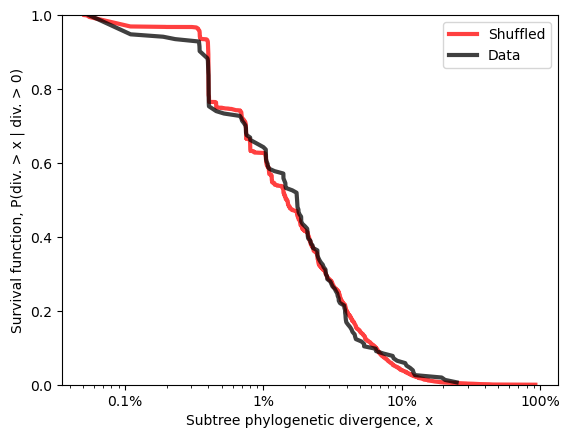

<Figure size 640x480 with 0 Axes>

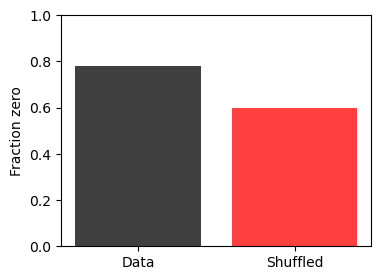

In [ ]:
x1, y1 = survival_func(subtree_divs[subtree_divs > 0])
x2, y2 = survival_func(shuffled_divs[shuffled_divs > 0])

zero_ct1 = np.sum(subtree_divs == 0)/len(subtree_divs)
zero_ct2 = np.sum(shuffled_divs == 0)/len(shuffled_divs)

plt.plot(x2[y2>0], y2[y2>0],color='red',label='Shuffled',linewidth=3,alpha=0.75)

plt.plot(x1[y1>0], y1[y1>0],color='black',label='Data',linewidth=3,alpha=0.75)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Subtree phylogenetic divergence, x')
plt.xticks([0.001,0.01,0.1,1],['0.1%','1%','10%','100%'])
plt.ylabel('Survival function, P(div. > x | div. > 0)')
plt.ylim([0,1])
plt.legend()
#plt.savefig(r'Figures\5A_Subtree_Divergence.pdf', format='pdf')

plt.show()

plt.figure()
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(['Data', 'Shuffled'], [zero_ct1, zero_ct2], color=['black', 'red'],alpha=0.75)
ax.set_ylabel('Fraction zero')
ax.set_ylim([0,1])
#plt.savefig(r'Figures\5A_inset_Zero_Counts.pdf', format='pdf')

plt.show()

In [ ]:
# FIGURE 4B and FIGURE 4C: Frequency of immigrant B cell lineages

freq_list = []
first_entry_list = []

folls = df_IGH_IF['follicle'].unique()
N_UMI = np.zeros(len(folls))
N_lineage = np.zeros(len(folls))

max_f = np.zeros(len(folls))
max_f_migrant = np.zeros(len(folls))
max_f_id = np.empty(len(folls),dtype='str')

prop_UMI_migrant = np.zeros(len(folls))
prop_lineage_migrant = np.zeros(len(folls))

for i in range(len(folls)):
    df_foll = df_IGH_IF[df_IGH_IF['follicle'] == folls[i]]
    N_UMI[i] = len(df_foll)

    running_migrant_UMI = 0
    running_migrant_lineage = 0
    lineages = df_foll['lineage_id'].unique()
    N_lineage[i] = len(lineages)

    for lineage in lineages:
        df_lin = df_foll[df_foll['lineage_id'] == lineage]
        if len(df_lin)/N_UMI[i] > max_f[i]:
            max_f[i] = len(df_lin)/N_UMI[i]
            max_f_id[i] = lineage

        if df_lin['v_mutations'].nunique() <= 1: continue

        lin_id = int(float(lineage))
        tree = Phylo.read("Data/Lineage_Seqs/Lineage_Trees/tree_lin_" + str(lin_id) + "_no_ef.newick", "newick")

        root_flag = False
        for clade in tree.find_clades():
            if clade.name and clade.name.startswith("ROOT"):
                tree.root_with_outgroup(clade)
                if clade.name == "ROOT__INFERRED": tree.collapse(clade)
                root_flag = True
                break
        if not root_flag: print("Error: No root found")

        label_tips(tree, df_IGH_IF, lineage, ignore_EF = True)
        fill_internal_nodes(tree,lineage, df_IGH_IF, track_dominant = True)

        if tree.root.metadata['foll'] != folls[i]:
            if len(df_lin)/N_UMI[i] > max_f_migrant[i]: max_f_migrant[i] = len(df_lin)/N_UMI[i]

            prop_lineage_migrant[i] += 1/N_lineage[i]
            prop_UMI_migrant[i] += len(df_lin)/N_UMI[i]

            first_entry_list.append(find_first_entry(tree, folls[i]))
            freq_list.append(len(df_lin)/N_UMI[i])

In [5]:
from collections import Counter

max_lineages = []
for foll in df_IGH_IF['follicle'].unique():
    df_foll = df_IGH_IF[df_IGH_IF['follicle'] == foll]
    lineage_counts = df_foll['lineage_id'].value_counts()
    max_lineage = lineage_counts.idxmax()
    max_lineages.append(max_lineage)

counts = Counter(max_lineages)
for lineage, count in counts.items():
    if count > 1:
        print(f"{lineage}: {count}")

111: 2
128: 2
192: 2
121: 2
154: 2


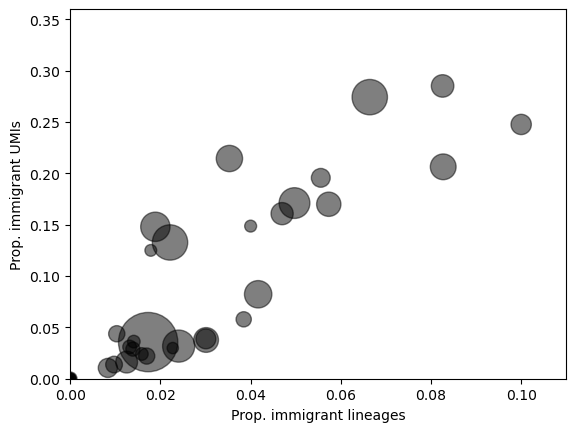

In [ ]:
plt.scatter(prop_lineage_migrant, prop_UMI_migrant, s=N_UMI, color='black',alpha=0.5)
#plt.scatter(prop_lineage_migrant_corr_stats[1,:],prop_UMI_migrant_corr_stats[1,:],color=[0.7,0.7,0.7])
plt.xlabel('Prop. immigrant lineages')
plt.ylabel('Prop. immigrant UMIs')
plt.xlim([0,0.11])
plt.ylim([0,0.36])
#plt.savefig(r'Figures\5B_Proportion_Immigrants.pdf', format='pdf')

plt.show()


In [ ]:
print("Prop. follicles where migrant is highest-frequency lineage:", np.sum(max_f == max_f_migrant)/len(max_f))
print("Prop. follicles where migrant is within 2x max lineage frequency:", np.sum(max_f <= 2*max_f_migrant)/len(max_f))

0.2702702702702703
0.4594594594594595


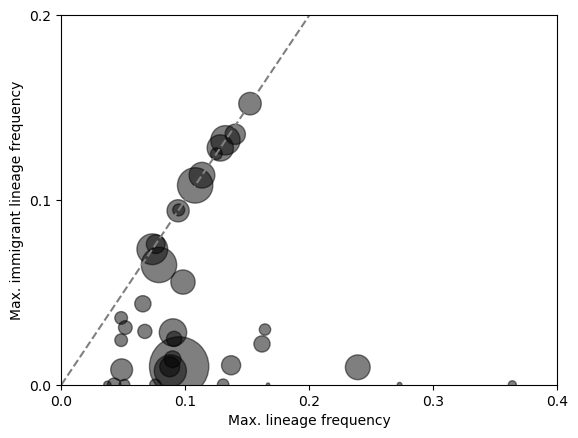

In [ ]:
plt.scatter(max_f, max_f_migrant,color='black',s=N_UMI,alpha=0.5)
plt.plot([0,0.4],[0,0.4],color='gray',linestyle='--')
plt.xlabel('Max. lineage frequency')
plt.ylabel('Max. immigrant lineage frequency')
plt.ylim([0,0.2])
plt.xlim([0,0.4])
plt.xticks([0,0.1,0.2,0.3,0.4])
plt.yticks([0,0.1,0.2])
plt.savefig(r'Figures\5C_Max_Frequency.pdf', format='pdf')
plt.show()